In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from read_db.CH import Getch
from scipy.stats import mannwhitneyu, ttest_ind, norm
from tqdm.auto import tqdm
plt.style.use('ggplot')

In [2]:
# импортируем данные за период с 29.11 по 05.12
data = Getch("select user_id, exp_group, \
countIf(action = 'view') as views, \
countIf(action = 'like') as likes, \
likes / views as ctr \
from simulator.feed_actions \
where toDate(time) >= '2021-11-29' and toDate(time) <= '2021-12-05' and \
exp_group in (0, 1) \
group by user_id, exp_group").df

In [3]:
data.head()

,user_id,exp_group,views,likes,ctr
0,26117,1,21,5,0.238095
1,138232,1,29,5,0.172414
2,49204,1,62,10,0.161290
3,49286,1,19,7,0.368421
4,145957,1,129,54,0.418605


### Рабочие гипотезы
- H0, статиcтически значимых различий между значениями ctr для контрольной и экспериментальной групп не обнаружено;
- H1, между значениями ctr для контрольной и экспериментальной групп обнаружены статистически значимые различия.

---

- H0, статиcтически значимых различий между значениями сглаженного ctr для контрольной и экспериментальной групп не обнаружено;
- H1, между значениями сглаженного ctr для контрольной и экспериментальной групп обнаружены статистически значимые различия.

---

- H0, статиcтически значимых различий между значениями метрики просмотров для контрольной и экспериментальной групп не обнаружено;
- h1, между значениями метрики просмотров для контрольной и экспериментальной групп обнаружены статистически значимые различия.

In [4]:
# функция для рассчета сглаженного ctr
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [5]:
# посчитаем глобальный ctr
global_ctr = data.likes.sum() / data.views.sum()
global_ctr

0.22149774745073217

In [6]:
# добавим столбец с сглаженным ctr в датасет
data['smoothed_ctr'] = data.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr, 5), axis=1)

In [7]:
# посчитаем среднее значение сглаженного ctr для контрольной группы
data[data.exp_group == 0].smoothed_ctr.mean()

0.22095848556206973

In [8]:
# посчитаем среднее значений сглаженного ctr для экспериментальной группы
data[data.exp_group == 1].smoothed_ctr.mean()

0.23413924189945767

In [10]:
# напишем функцию для проверки 
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # нарисуем график распределения
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Распределение статистик бутстрэп-подвыборок")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

### Распределение статистик  метрики CTR через бутстрэп

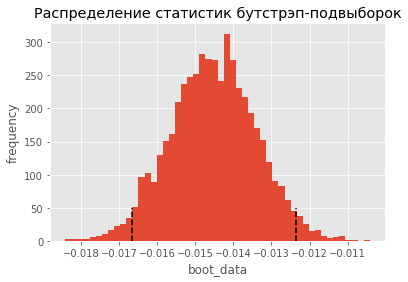

In [11]:
# посмотрим на распределение статистик метрики ctr для контрольной и экспериментальной групп,\
# разница двух распределений, доверительный интервал и p-values
booted_data_mean_ctr = get_bootstrap_mean(data[data.exp_group == 0].ctr, data[data.exp_group == 1].ctr, boot_it = 5000)

#### Значения распределены нормально.

In [12]:
# выведем p-value
booted_data_mean_ctr['p_value']

1.0043875102366065e-38

In [13]:
# выведем доверительный интервал
booted_data_mean_ctr['ci']

,0
0.025,-0.016668
0.975,-0.012353


### Сравнение метрики CTR

In [14]:
# среднее значение ctr в контрольной группе
round(data[data.exp_group == 0].ctr.mean() * 100, 2)

22.2

In [15]:
# среднее значение ctr в экспериментальной группе
round(data[data.exp_group == 1].ctr.mean() * 100, 2)

23.65

In [16]:
# критерий Манна-Уитни для ctr
mannwhitneyu(data[data.exp_group == 0].ctr, data[data.exp_group == 1].ctr)

MannwhitneyuResult(statistic=75455843.5, pvalue=9.550851479423863e-51)

In [17]:
# критерий Стьюдента для ctr
stats.ttest_ind(data[data.exp_group == 0].ctr, data[data.exp_group == 1].ctr, equal_var=False)

Ttest_indResult(statistic=-13.161168998357258, pvalue=1.9633095094681595e-39)

### Распределение статистик сглаженного CTR через бутстрэп

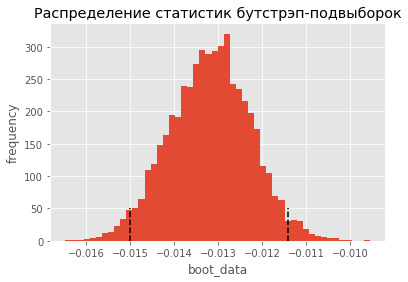

In [18]:
# посмотрим на распределение статистик сглаженного ctr для контрольной и экспериментальной групп, разница двух распределений, доверительный интервал и p-values
booted_data_mean_smoothed_ctr = get_bootstrap_mean(data[data.exp_group == 0].smoothed_ctr, data[data.exp_group == 1].smoothed_ctr, boot_it = 5000)

#### Значения распределены нормально.

In [19]:
# выведем p-value
booted_data_mean_smoothed_ctr['p_value']

1.4491180277604201e-46

In [20]:
# выведем доверительный интервал
booted_data_mean_smoothed_ctr['ci']

,0
0.025,-0.015005
0.975,-0.011413


### Сравнение сглаженного CTR

In [21]:
# среднее значение сглаженного ctr в контрольной группе
round(data[data.exp_group == 0].smoothed_ctr.mean() * 100, 2)

22.1

In [22]:
# среднее значение сглаженного ctr в экспериментальной группе
round(data[data.exp_group == 1].smoothed_ctr.mean() * 100, 2)

23.41

In [23]:
# критерий Манна-Уитни для сглаженного ctr
mannwhitneyu(data[data.exp_group == 0].smoothed_ctr, data[data.exp_group == 1].smoothed_ctr)

MannwhitneyuResult(statistic=75190942.5, pvalue=1.227686809848908e-53)

In [24]:
# критерий Стьюдента для сглаженного ctr
stats.ttest_ind(data[data.exp_group == 0].smoothed_ctr, data[data.exp_group == 1].smoothed_ctr, equal_var=False)

Ttest_indResult(statistic=-14.27852163637724, pvalue=4.451257637520532e-46)

### Распределение статистик метрики просмотров через бутстрэп

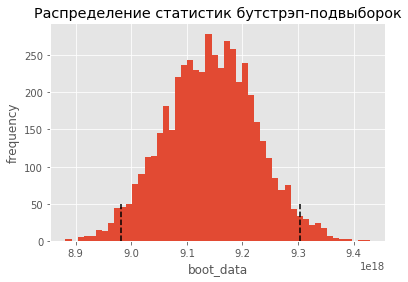

In [25]:
# посмотрим на распределение статистик просмотров для контрольной и экспериментальной групп, разница двух распределений, доверительный интервал и p-values
booted_data_mean_views = get_bootstrap_mean(data.query('exp_group == 0').views, data.query('exp_group == 1').views, boot_it = 5000)

#### Значения распределены нормально.

In [26]:
# выведем p_value
booted_data_mean_views['p_value']

0.0

In [27]:
# выведем доверительный интервал
booted_data_mean_views['ci']

,0
0.025,8.980764e+18
0.975,9.302858e+18


### Сравнение метрики просмотров

In [28]:
# среднее значение views в контрольной группе
round(data[data.exp_group == 0].views.mean(), 2)

61.3

In [29]:
# среднее значение views в экспериментальной группе
round(data[data.exp_group == 1].views.mean(), 2)

61.2

In [30]:
# критерий Манна-Уитни для просмотров
mannwhitneyu(data[data.exp_group == 0].views, data[data.exp_group == 1].views)

MannwhitneyuResult(statistic=84472052.0, pvalue=0.48586381818421304)

In [31]:
# критерий Стьюдента для просмотров
stats.ttest_ind(data[data.exp_group == 0].views, data[data.exp_group == 1].views, equal_var=False)

Ttest_indResult(statistic=0.18557426218615805, pvalue=0.8527800866422888)

### Вывод
#### Для проведения анализа было выбрано три метода: bootstap, ttest и mannwthitneyu.

#### Результаты сравнения ctr по bootstap, ttest и mannwthitneyu
- p-value < 0.05, доверительный интервал - (-0.017; -0.013);
- среднее значение ctr в контрольной группе - 21.82%, среднее значение ctr в экспериментальной группе - 23.38%;
- т.к между группами зафиксированы статистически значимые различия и в экспериментальной группе среднее значение ctr оказалось больше, то мы можем отклонить гипотезу H0 о равенстве средних значений ctr между контрольной и экспериментальной группами.

---

#### Результаты сравнения сглаженного ctr по bootstap, ttest и mannwthitneyu
- p-value < 0.05, доверительный интервал - (-0.015; -0.012);
- среднее значение ctr в контрольной группе, 21.77%, среднее значение ctr в экспериментальной группе 23.19%;
- т.к между группами зафиксированы статистически значимые различия и в экспериментальной группе среднее значение сглаженного ctr оказалось больше, то мы можем отклонить нулевую гипотезу H0 о равенстве средних значений сглаженного ctr между контрольной и экспериментальной группами.

---

#### Результаты сравнения метрики просмотров по bootstap, ttest и mannwthitneyu
- p-value = 0, доверительный интервал - (8.9е+18; 9.2е+18);
- среднее значение метрики просмотров в контрольной группе - 74.95%, среднее значение метрики просмотров в экспериментальной группе - 74.39%;
- статистически значимых различий между группами по метрики просмотров зафиксировано не было.

---

#### Рекомендации
- Похоже, что мы все же можем выкатывать новый алгоритм рекомендаций на всех пользователей, ведь значения ctr и сглаженного ctr изменились в большую сторону, а метрика просмотров не изменилась. Кажется, мы получили то, что хотели.